It is an overt fact that the <b>Rainfall</b> feature is very highly correlated with the target variable in respect of Mutual Information score and Point-BiSerial Coefficient. This situation can give rise to an overfitting problem. For example, I used  the Rainfall feature in training, model metrics quickly increased and to be 100 % in my trial with a CatBoostModel. This problem in machine learning is the target leakage [1,2]. This is why I dropped the <b>Rainfall</b> feature.

I have used the following methods.

* Feature engineering for timeseries data (creating <b>Cyclical Features</b>),
* Feature selection for solving <b>the target leakage problem</b> (dropping Rainfall feature),
* A tuned CatBoost Model (with optuna),
* Feature Explanation with <b>SHAP</b>,
* <b>Conformal Prediction</b> for calibration,


## My Another Projects
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)


## References
1. https://en.wikipedia.org/wiki/Leakage_(machine_learning)
2. https://dataintegration.info/detect-multicollinearity-target-leakage-and-feature-correlation-with-amazon-sagemaker-data-wrangler
3. https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from scipy import stats
from sklearn.feature_selection import mutual_info_classif

import optuna
import catboost
from catboost import CatBoostClassifier, Pool

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

import shap

shap.initjs()

SEED = 10

# <span style="color:#e74c3c;"> Reading </span> Data


In [2]:
data = pd.read_csv('/kaggle/input/weatherdatabangladesh/Weather_Data.csv')
data.index = pd.to_datetime( data['Date'])
data.drop(['Date'], axis = 1, inplace = True ) 
data.head()

,Temp9am,Temp3pm,MinTemp,MaxTemp,Rainfall,RainToday,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm
Date,,,,,,,,,,,,,,,,,,,,
2013-01-02,20.7,20.9,19.5,22.4,15.6,Yes,6.2,0.0,W,41,S,SSW,17,20,92,84,1017.6,1017.4,8,8
2013-02-02,22.4,24.8,19.5,25.6,6.0,Yes,3.4,2.7,W,41,W,E,9,13,83,73,1017.9,1016.4,7,7
2013-03-02,23.5,23.0,21.6,24.5,6.6,Yes,2.4,0.1,W,41,ESE,ESE,17,2,88,86,1016.7,1015.6,7,8
2013-04-02,21.4,20.9,20.2,22.8,18.8,Yes,2.2,0.0,W,41,NNE,E,22,20,83,90,1014.2,1011.8,8,8
2013-05-02,22.5,25.5,19.7,25.7,77.4,Yes,4.8,0.0,W,41,NNE,W,11,6,88,74,1008.3,1004.8,8,8


# <span style="color:#e74c3c;"> Preprocessing </span> 


In [3]:
# Encoding 3 categorical features for feature selection stage

lb1 = LabelEncoder()
data['WindGustDir'] = lb1.fit_transform(data['WindGustDir'])

lb2 = LabelEncoder()
data['WindDir9am'] = lb2.fit_transform(data['WindDir9am'])

lb3 = LabelEncoder()
data['WindDir3pm'] = lb3.fit_transform(data['WindDir3pm'])

# <span style="color:#e74c3c;"> Feature </span> Extraction (Cyclical Feature)


In [4]:
# Creating cyclical time features 

def creata_new_feature(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter

    return df

data_new = creata_new_feature(data)

data_new['day_sin'] = np.sin(data_new['dayofweek']*(2.*np.pi/30))
data_new['day_cos'] = np.cos(data_new['dayofweek']*(2.*np.pi/30))

data_new['month_sin'] = np.sin(data_new['month']*(2.*np.pi/12))
data_new['month_cos'] = np.cos(data_new['month']*(2.*np.pi/12))

data_new['quarter_sin'] = np.sin(data_new['quarter']*(2.*np.pi/4))
data_new['quarter_cos'] = np.sin(data_new['quarter']*(2.*np.pi/4))

data_new.drop(['dayofweek', 'month', 'quarter'], axis = 1, inplace = True)

In [5]:
# Encoding target feature 

lb = LabelBinarizer()
data_new['RainToday'] = lb.fit_transform(data_new['RainToday'])

data_new.head()

,Temp9am,Temp3pm,MinTemp,MaxTemp,Rainfall,RainToday,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,day_sin,day_cos,month_sin,month_cos,quarter_sin,quarter_cos
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,20.7,20.9,19.5,22.4,15.6,1,6.2,0.0,13,41,...,1017.6,1017.4,8,8,0.406737,0.913545,0.500000,8.660254e-01,1.000000e+00,1.000000e+00
2013-02-02,22.4,24.8,19.5,25.6,6.0,1,3.4,2.7,13,41,...,1017.9,1016.4,7,7,0.866025,0.500000,0.866025,5.000000e-01,1.000000e+00,1.000000e+00
2013-03-02,23.5,23.0,21.6,24.5,6.6,1,2.4,0.1,13,41,...,1016.7,1015.6,7,8,0.866025,0.500000,1.000000,6.123234e-17,1.000000e+00,1.000000e+00
2013-04-02,21.4,20.9,20.2,22.8,18.8,1,2.2,0.0,13,41,...,1014.2,1011.8,8,8,0.207912,0.978148,0.866025,-5.000000e-01,1.224647e-16,1.224647e-16
2013-05-02,22.5,25.5,19.7,25.7,77.4,1,4.8,0.0,13,41,...,1008.3,1004.8,8,8,0.587785,0.809017,0.500000,-8.660254e-01,1.224647e-16,1.224647e-16


# <span style="color:#e74c3c;"> Feature </span> Importance

It is an overt fact that the <b>Rainfall</b> feature is very highly correlated with the target variable in respect of Mutual Information score and Point-BiSerial Coefficient. This situation can give rise to an overfitting problem. For example, I used  the Rainfall feature in training, model metrics quickly increased and to be 100 % in my trial with a CatBoostModel. This problem in machine learning is the target leakage. This is why I dropped the Rainfall feature.

In [6]:
# Mutual inf for linear relationship, Point-BiSerial for nonlinear relationship
y = data_new.pop('RainToday')
X = data_new

point_biserial_coefs = []

for i in range(X.shape[1]):
    coef = stats.pointbiserialr(X.iloc[:,i], y)[0]
    point_biserial_coefs.append(coef)
    
    
mutual_inf = mutual_info_classif(X,y)


feature_importance = pd.DataFrame({'Mutual Inf':mutual_inf, 'Point-BiSerial':point_biserial_coefs}, index = X.columns )
feature_importance.sort_values(by = 'Point-BiSerial', ascending = False)

,Mutual Inf,Point-BiSerial
Humidity3pm,0.140957,0.477580
Cloud3pm,0.108594,0.415801
Cloud9am,0.052465,0.338545
Humidity9am,0.049897,0.335966
Rainfall,0.077059,0.296120
WindGustSpeed,0.003263,0.145382
WindDir3pm,0.045686,0.100092
MinTemp,0.000000,0.082804
WindSpeed9am,0.000000,0.065510
month_cos,0.000000,0.012797


In [7]:
# Dropping the most correlated feature
X.drop(['Rainfall'], axis = 1, inplace = True)

# <span style="color:#e74c3c;"> Creating </span> Train, Test Set

In [8]:
X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size = 0.25, random_state = SEED, shuffle = True)

print('train  ->', X_train.shape)
print('test  ->', X_test.shape)


# Applying scaling

MM = MinMaxScaler()
MM_fit = MM.fit(X_train)

X_train = MM_fit.transform(X_train)
X_test = MM_fit.transform(X_test)

train  -> (2453, 24)
test  -> (818, 24)


# <span style="color:#e74c3c;"> CatBoostClassifier </span> Model

In [9]:
# CatBoostClassifier model tuned with optuna

model = CatBoostClassifier(iterations = 3132, learning_rate = 0.014560419631497297, depth= 6,
                           l2_leaf_reg = 0.00045179552801297336, bootstrap_type = 'Bayesian',
                           random_strength = 3.1473649059780663e-07, bagging_temperature = 2.4816990687406735,
                           od_type =  'Iter', od_wait = 27, verbose = 0)

model.fit(X_train, y_train)

# <span style="color:#e74c3c;"> Test </span> Metrics

In [10]:
# predictions and scores

pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
acc = accuracy_score(y_test, pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Accuracy Score : {0:.2f} %'.format(acc*100))

Mean Squared Error : 0.15648
Accuracy Score : 84.35 %


# <span style="color:#e74c3c;"> Classification </span> Report

In [11]:
# classification report

clf_report = classification_report(y_test, pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       592
           1       0.81      0.57      0.67       226

    accuracy                           0.84       818
   macro avg       0.83      0.76      0.78       818
weighted avg       0.84      0.84      0.83       818



# <span style="color:#e74c3c;"> Confusion </span> Matrix

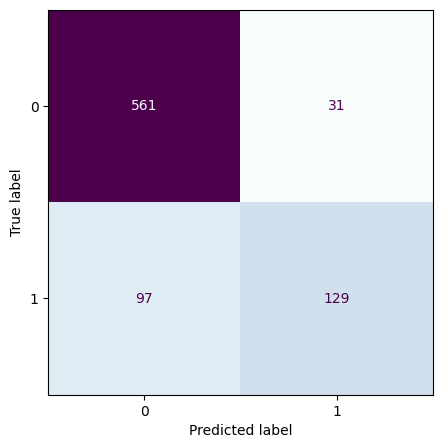

In [12]:
cm = confusion_matrix(y_test, pred)
cmd = ConfusionMatrixDisplay(cm) 

fig, ax = plt.subplots(figsize=(5, 5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

# <span style="color:#e74c3c;"> ROC AUC </span> Curve

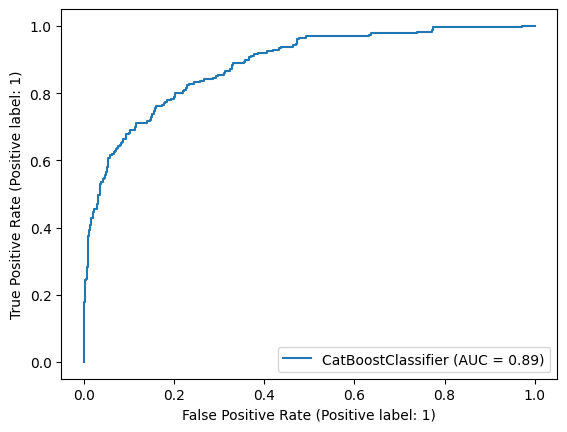

In [13]:
RocCurveDisplay.from_estimator(model, X_test, y_test)

# <span style="color:#e74c3c;"> Feature Explanation with </span> SHAP

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(pd.DataFrame(X_test, columns = X.columns))

In [15]:
shap.plots.force(shap_values[2, ...])

In [16]:
shap.plots.force(shap_values[30, ...])

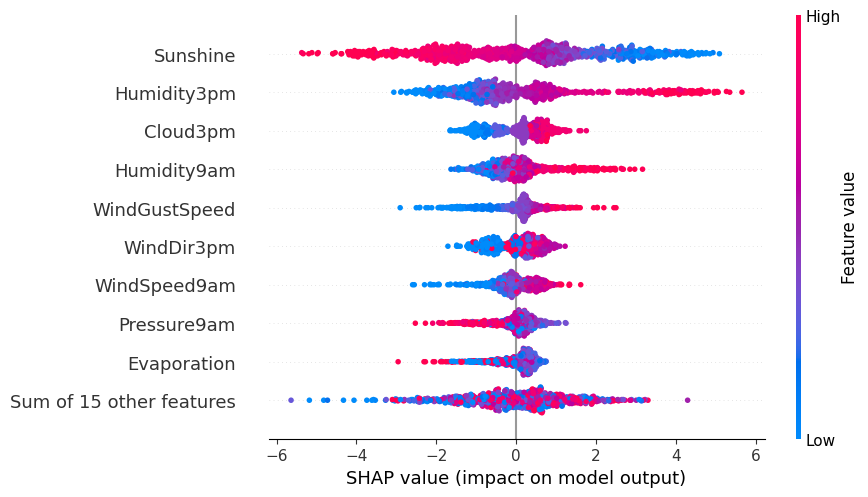

In [17]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

# <span style="color:#e74c3c;"> Conformal </span> Prediction

In [18]:
# calibrating data for the conformal prediction

# original code from -> https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

cat_isotonic = CalibratedClassifierCV(model, cv = 8, method="isotonic")
cat_sigmoid = CalibratedClassifierCV(model, cv = 8, method="sigmoid")

clf_list = [
    (model, "CatBoost"),
    (cat_isotonic, "CatBoost + Isotonic"),
    (cat_sigmoid, "CatBoost + Sigmoid")]

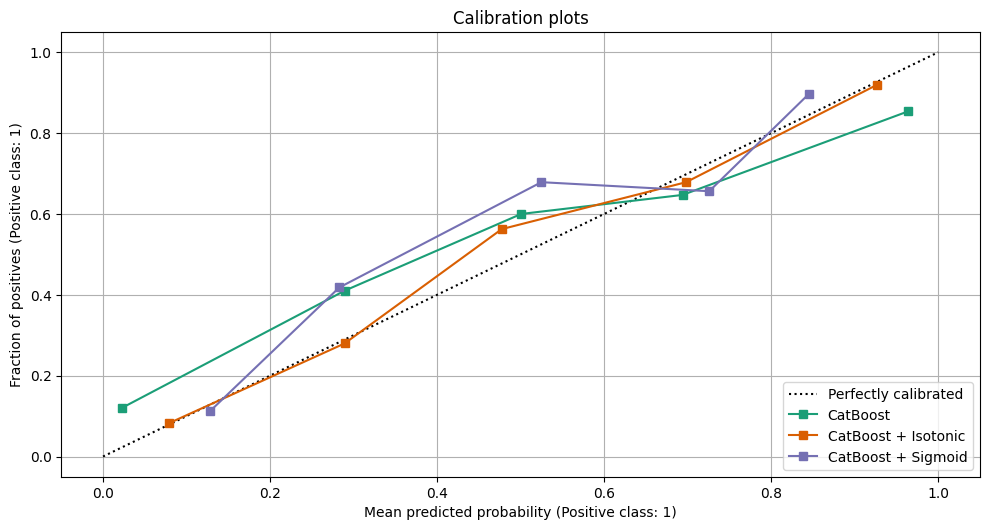

In [19]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)

    display = CalibrationDisplay.from_estimator( clf, X_test, y_test, n_bins=5, name=name,
        ax=ax_calibration_curve, color=colors(i) )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")


plt.tight_layout()
plt.show()

# <span style="color:#e74c3c;"> Prediction Isotonic </span> CalibratedClassifierCV 

In [20]:
# Isotonic method is gained a small improvement in our predictions

iso_pred = cat_isotonic.predict(X_test)
mse = mean_squared_error(y_test, iso_pred)
acc = accuracy_score(y_test, iso_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Accuracy Score : {0:.2f} %'.format(acc*100))

Mean Squared Error : 0.15281
Accuracy Score : 84.72 %


# <span style="color:#e74c3c;"> CalibratedClassifierCV</span> Classification Report 

In [21]:
# classification report

clf_report = classification_report(y_test, iso_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       592
           1       0.83      0.57      0.67       226

    accuracy                           0.85       818
   macro avg       0.84      0.76      0.79       818
weighted avg       0.84      0.85      0.84       818



# <span style="color:#e74c3c;"> CalibratedClassifierCV</span> Confusion Matrix 

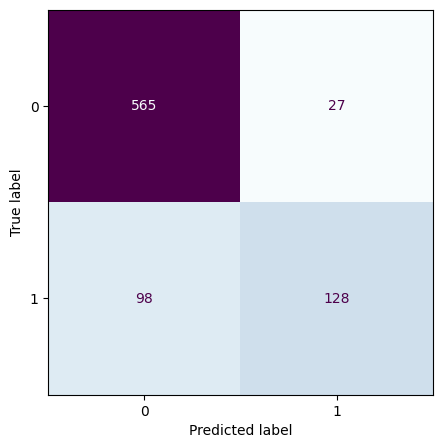

In [22]:
cm = confusion_matrix(y_test, iso_pred)
cmd = ConfusionMatrixDisplay(cm) 

fig, ax = plt.subplots(figsize=(5, 5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

# <span style="color:#e74c3c;"> CalibratedClassifierCV</span> ROC AUC Curve

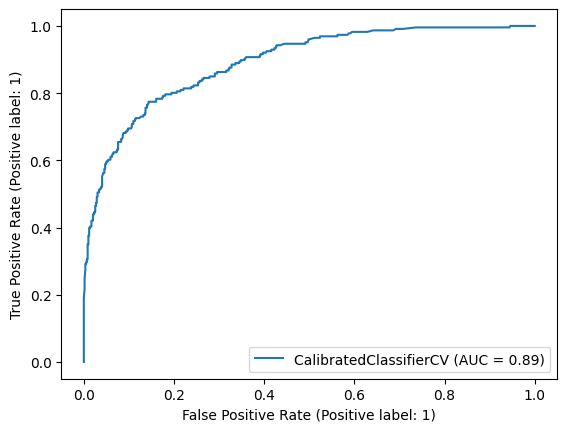

In [23]:
RocCurveDisplay.from_estimator(cat_isotonic, X_test, y_test)